# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

**Datos entorno desarrollo:**  
**SO:** Ubuntu Server, virtualizado en VirtualBox.  
**Cores:** 32.  
**RAM:** 30.7 Gb.  
**Librerías empleadas:** `caret`, `ggplot2`, `gridExtra`, `reshape2` y `doMC`.  

## Introducción

Esta práctica de aprendizaje automático se enmarca en explorar los distintos paradigmas de clasificación estudiados en la asignatura para seleccionar aquel que mejor prediga el tipo de cancer según la información de expresión de los genes de distintas muestras de pacientes reales.

Para ello se evaluarán los paradigmas de clasificación **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte** a través del paquete `caret` de R. 

Finalmente se realizará la comparación de los resultados aportados por los diferentes paradigmas y se seleccionará aquel que mejor precisión tenga como _el mejor_.


Empezamos configurando R e importanto el paquete `caret`. De la misma forma cargamos las librerías necesarias que vamos a utilizar durante el desarrollo de la práctica y eliminamos los warnings de nuestro script para limpiar las salidas.

In [1]:
# Eliminamos los warnings del script ya que ensucian el script
options(warn=-1)

# Realizamos los imports necesarios
library(caret)
#library(mlbench)
library(ggplot2)
library(gridExtra)
library(reshape2)

Loading required package: lattice

Loading required package: ggplot2



## Carga de datos en R

Una vez tenemos R configurado y con las librerías necesarias cargadas, importamos los datos sobre los que vamos a dearrollar nuestros modelos. Para ello descargamos en el directorio `/data` el siguiente banco de [datos](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq) y lo importamos con el siguiente código.

In [2]:
load("har.RData")

El banco de datos `tcga` contiene 20531 variables y 801 instancias. Para manejar tal cantidad de columnas en algunos casos haría falta una cantidad de memoria superior a la de un ordenador típico. Por esto solamente vamos a usar 100 variables que serán elegidas aletaroiamente según nuestro identificador universitario. De esta forma obtendremos un banco de datos de 100 variables y 801 instancias.

In [3]:
# Configuramos nuestro identificador universitario
uo <- 236856

set.seed(uo) #Pon aquí los número de tu UO
filtered <- har[sample(nrow(har)-1,10000),]

filtered$user<-NULL
filtered$gender<-NULL
filtered$how_tall_in_meters<-NULL
filtered$weight<-NULL
filtered$body_mass_index<-NULL

# Mostramos los datos con los que trabajaremos.
head(filtered)

,age,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
25721,28,-24,41,-25,-252,-328,-362,26,106,-88,-150,-95,73,sitting
145066,28,-10,83,-101,-492,-516,-614,36,65,-103,-172,-87,72,walking
110991,46,-13,97,-86,11,83,-121,40,98,-66,-180,-87,55,standingup
99440,31,-5,97,-123,0,90,-139,39,116,-83,-182,-81,53,standing
164480,75,-17,94,-143,-15,76,-83,-10,141,-90,-183,-95,52,walking
37849,31,-1,67,-66,-24,-29,-25,62,55,-102,-94,-126,67,sitting


Como vemos en la tabla anterior cada columna se corresponde con la información de expresión de un gen y la última columna identifica el tipo de cáncer. Así mismo en la tabla anterior se puede ver que hay dos genes en particular que presentan valores de 0 para las entradas mostradas, en el caso de que fueran 0 en todas y cada una de las instancias podrían eliminarse, sin embargo para esto debemos de ver el sumario de los datos.

In [4]:
summary(filtered)

      age              x1                y1               z1         
 Min.   :28.00   Min.   :-70.000   Min.   : 10.00   Min.   :-601.00  
 1st Qu.:28.00   1st Qu.:-12.000   1st Qu.: 77.00   1st Qu.:-120.00  
 Median :31.00   Median : -6.000   Median : 94.00   Median : -98.00  
 Mean   :38.01   Mean   : -6.568   Mean   : 88.11   Mean   : -93.09  
 3rd Qu.:46.00   3rd Qu.:  0.000   3rd Qu.:101.00   3rd Qu.: -64.00  
 Max.   :75.00   Max.   : 47.000   Max.   :212.00   Max.   :  67.00  
       x2               y2                z2               x3         
 Min.   :-494.0   Min.   :-517.00   Min.   :-617.0   Min.   :-499.00  
 1st Qu.: -36.0   1st Qu.: -29.00   1st Qu.:-141.0   1st Qu.:  10.00  
 Median :  -9.0   Median :  28.00   Median :-119.0   Median :  22.00  
 Mean   : -87.8   Mean   : -51.48   Mean   :-175.1   Mean   :  18.51  
 3rd Qu.:   4.0   3rd Qu.:  86.00   3rd Qu.: -29.0   3rd Qu.:  35.00  
 Max.   : 459.0   Max.   : 295.00   Max.   :  63.0   Max.   : 499.00  
       y3    

Con la tabla anterior podemos ver que todas las variables pueden ser relevantes para el aprendizaje y por tanto no realizaremos ninún otro pre-proceso, a parte del de filtrado, de datos.

Observando los datos en formato de tabla es muy complicado sacar cualquier conclusión preliminar sobre nuestros datos, por eso los exploraremos por médio de gráficas (para mejorar la resolución de las gráficas seleccionaremos únicamente los últimos 4 genes).

Using class as id variables



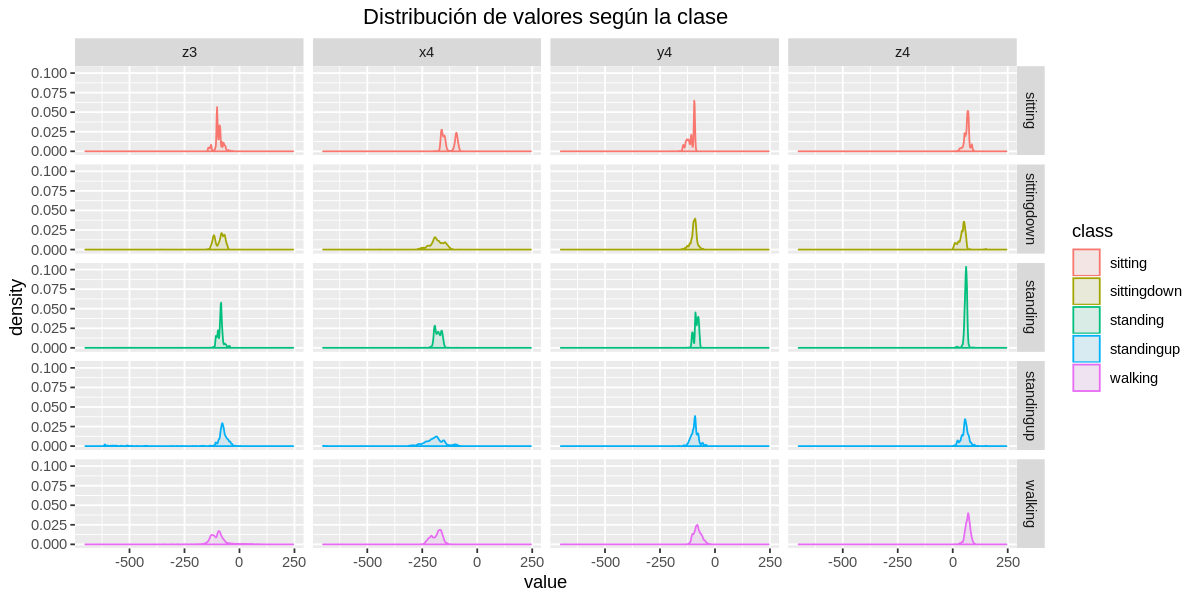

In [5]:
# Tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=5)

ggplot(melt(filtered[(length(filtered) - 4):length(filtered)]),
       aes(x=value,color=class, fill = class)) + 
       geom_density(adjust = 1/2, alpha=0.1) +
       ggtitle("Distribución de valores según la clase") +
       theme(plot.title = element_text(hjust = 0.5)) + facet_grid(rows = class~variable)

En la gráfica anterior vemos los valores de las variables de forma individuales, lo que nos puede dar una idea inicial del tipo de probelma que es y que modelo se ajustaría mejor, sin embargo lo que nos interesará será ver como se relacionan las variables entre ellas, ya que un modelo predictivo intenta combinar las variables y sus interacciones.

Para ello vamos a ver la relación entre la información de expresión de los 2 últimos genes y el tipo de cáncer al que pertenencen.

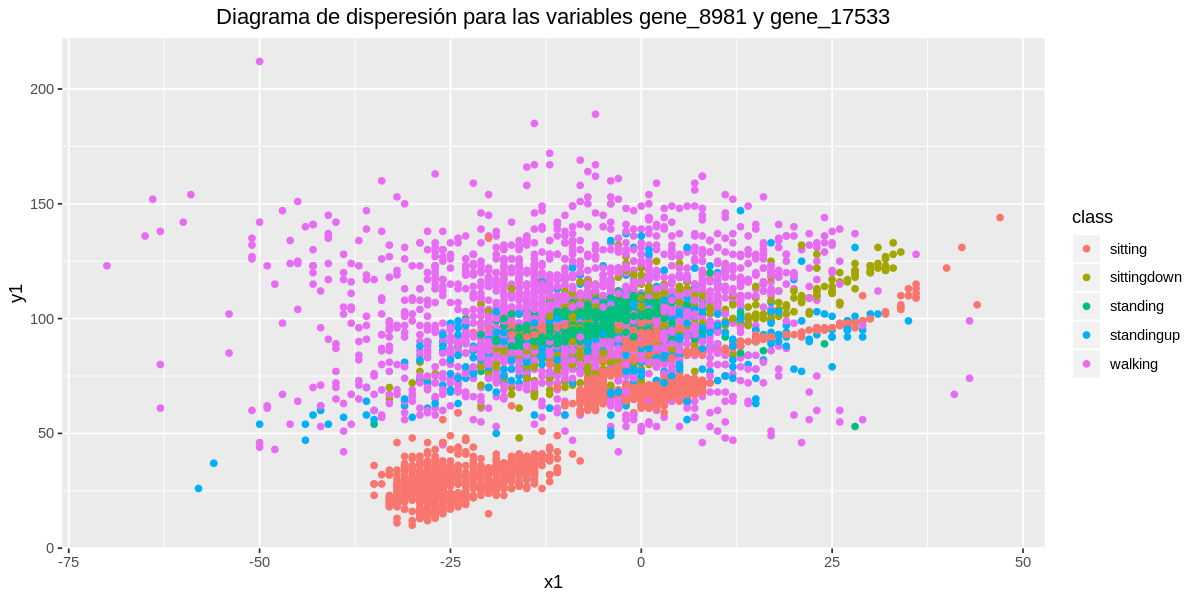

In [6]:
ggplot(filtered, aes(x=x1,y=y1,z=z1,color=class)) + 
    geom_point() +
    ggtitle("Diagrama de disperesión para las variables gene_8981 y gene_17533") +
    theme(plot.title = element_text(hjust = 0.5))

Podríamos realizar la gráfica anterior 16 veces (1 para cada par de genes), sin embargo para verlo todo en un mismo bloque emplearemos una variante de la función makePairs vista en práctica

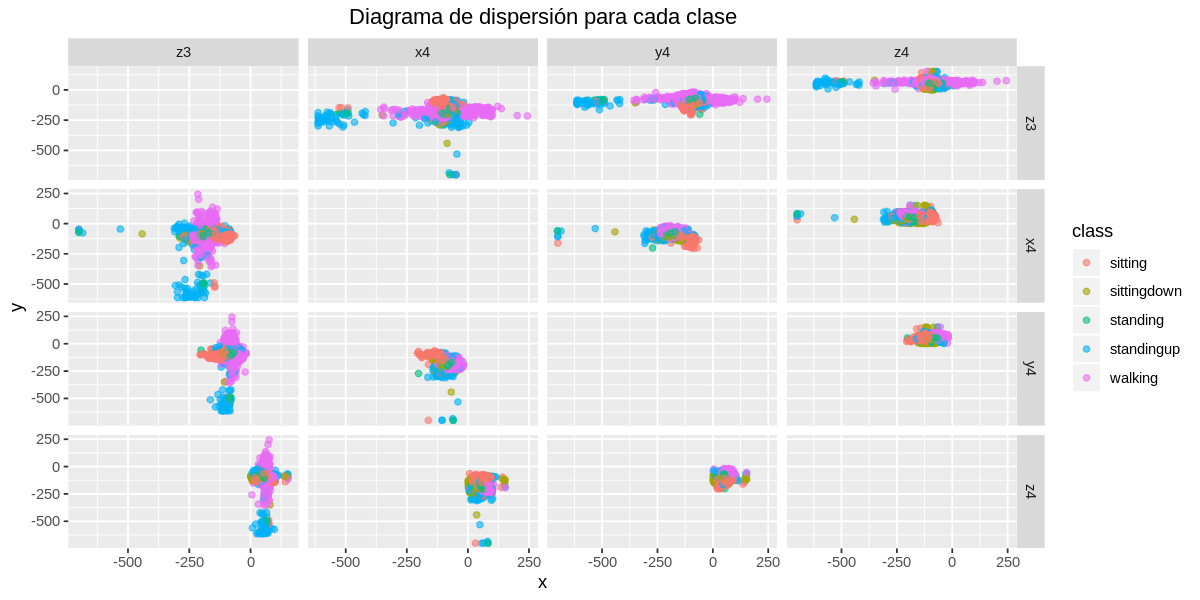

In [7]:
makePairs <- function(data,classIndex) { 
    dfm <- NULL
    for(i in 1:ncol(data)){
        if(i==classIndex)
          next
        for(j in 1:ncol(data)){ 
            if(j==classIndex)
                next
            if(i==j)
                next
            dfm <- rbind(dfm,data.frame(x=data[,i], y=data[,j], 
                                        Var1=colnames(data)[i], 
                                        Var2=colnames(data)[j],
                                        class=data[,classIndex]))
        }
    }
    dfm$Var2 <- relevel(dfm$Var2,levels(dfm$Var1)[1])
    dfm 
}
            
dataToPlot <- makePairs(filtered[(length(filtered) - 4):length(filtered)], 5)
ggplot(dataToPlot, aes_string(x = "x", y = "y")) + 
            facet_grid(Var1 ~ Var2, scales = "free") + 
            geom_point(aes(colour=class), alpha=0.6) + 
            ggtitle("Diagrama de dispersión para cada clase") +
            theme(plot.title = element_text(hjust = 0.5))

Evidentemente las conclusiones están limitadas por que sólo vemos relaciones en dos dimensiones, pero aún con esta limitación realizar esta tarea es importante para entender peculiaridades de los datos, detectar posibles problemas y contrastar lo que hemos podido inferir con lo que un modelo dice.

Una vez hemos entendido los datos sobre los que vamos a trabajar tenemos que realizar 2 particiones, una con la que entrenaremos nuestros modelos y otra con la que los validaremos. En este caso yaque tenemos 801 instancias y sólo 100 variables escogeremos un 75% de los datos para entrenamiento y un 25% para la validación.

In [8]:
inTrain <- createDataPartition(
    # indicamos la clase
    y = filtered$class,
    
    # el porcentaje de instancias para entrenamiento
    p = .75,
    
    # controla el formato de salida
    list = FALSE
)

# Definimos nuestras particiones de entrenamiento y validación.
training <- filtered[ inTrain,]
testing <- filtered[-inTrain,]

## Esquemas de validación

Conocemos que existen distintos tipos de validación, cada uno con sus ventajas y desventajas. Sin embargo, para nuestro problema donde tenemos 801 instancias y 100 variables el que más adecuado a emplear será el de validación cruzada con k 10 (número de subconjuntos a usar en la validación). Esto viene dado de que a priori, no hay un único validador que sea el mejor para todos y cada uno de los modelos, sin embargo tras realizar una comparación entre ellos es el de validación cruzada el que nos ofrece una mejor porcentaje de acierto.

In [9]:
crossValidation <- trainControl(method = "cv")

## Árbol de decisión

De acuerdo con la teoría, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Por lo tanto, y teniendo en cuenta nuestros datos, parece un modelo que nos dará unos buenos resultados, sin embargo, vamos a contrastar esta hipótesis.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

In [10]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    class ~ .,
    data = training,
    method = "J48",
    trControl = crossValidation,
    # Empleamos C=0.04 y M=2 ya que son los valores que tras explorar
    # nos han dado mejor resultado y realizar siempre la exploración
    # de valores es demasiado lenta.
    tuneGrid = data.frame(C=0.04, M=2)
)

**A partir de este punto podemos emplear multriproceso para los entrenamientos. Para aprovechar al máximo los recursos del ordenador emplearemos el paquete `multicore`. Debemos de tener en cuenta que actualmente R sólo da soporte a múltiples núcleos en Linux, por lo tanto si se ejecuta desde otro S.O. es de esperar que no funcione, en ese caso se pueden eliminar las siguientes lineas y todo funcionará sin problemas en un solo core.**

In [11]:
library(doMC)

# Leave always one core free for other processes.
nCores <- detectCores(all.tests = FALSE, logical = TRUE) -1
registerDoMC(cores = nCores)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [12]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
    class ~ .,
    data = training,
    method = "rpart",
    trControl = crossValidation,
    # Exploramos los resultados para 200 valores de cp crecientes desde 0.0.
    tuneLength = 200
)

In [13]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
    class ~ .,
    data = training,
    method = "rpart2",
    trControl = crossValidation,
    # Exploramos los resultados hasta una profundidad de 8, que es la
    # profundidad máxima del arbol.
    tuneLength = 8
)

Para comparar los modelos de manera inicial emplearemos el sistema de matriz de confusión.

In [14]:
# Datos del modelo rpart2 y matriz de confusión para los datos de validación
c4.5Fit$results[rownames(c4.5Fit$bestTune),1:4]
confusionMatrix(predict(c4.5Fit,testing), factor(testing$class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpartFit$results[rownames(rpartFit$bestTune),1:4]
confusionMatrix(predict(rpartFit,testing), factor(testing$class))$overall[1:4]

# Datos del modelo rpart2 y matriz de confusión para los datos de validación
rpart2Fit$results[rownames(rpart2Fit$bestTune),1:4]
confusionMatrix(predict(rpart2Fit,testing), factor(testing$class))$overall[1:4]

C,M,Accuracy,Kappa
<dbl>,<dbl>,<dbl>,<dbl>
0.04,2,0.944676,0.9257502


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9491593     0.9317832     0.9398039     0.9574429

cp,Accuracy,Kappa,AccuracySD
<dbl>,<dbl>,<dbl>,<dbl>
0,0.9253555,0.8999448,0.005549322


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9303443     0.9064253     0.9196476     0.9400181

,maxdepth,Accuracy,Kappa,AccuracySD
,<dbl>,<dbl>,<dbl>,<dbl>
8,8,0.84604,0.790929,0.01426695


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8474780     0.7928500     0.8327728     0.8613634

De los modelos datos anteriores podemos extraer direfentes conclusiones preliminares. Por ejemplo, tanto rpart como rpart2 obtiene una precisión mayor sobre los datos de entrenamiento que j48, sin embargo cuando realizamos la validación externa se puede observar que es precisamente j48 el que obtiene un resultado superior a rpart y rpart2. 

Sin embargo antes de realizar la conclusión de que j48 es el modelo más preciso debemos de realizar algunas comparaciones para ver si la mejora es significativa, o por la contra los resultados de los modelos son equivalentes. En este caso como rpart y rpart2 obtienen exactamente los mismos resultados tanto para datos de entrenamiento como para datos de validación realizar la comparación entre c4.5 y rpart será suficiente para extraer conclusiones de los 3 modelos.

In [15]:
# Test binomial entre c4.5(j48) y rpart 
binom.test(c(round(confusionMatrix(predict(c4.5Fit,testing), factor(testing$class))$overall[1]),
             round(1-confusionMatrix(predict(c4.5Fit,testing), factor(testing$class))$overall[1])
            )*nrow(testing),
           p = confusionMatrix(predict(rpartFit,testing), factor(testing$class))$overall[1])

# Test entre c4.5 y rpart de validación cruzada.
t.test(c4.5Fit$resample$Accuracy,rpartFit$resample$Accuracy,paired = T)


	Exact binomial test

data:  c(round(confusionMatrix(predict(c4.5Fit, testing), factor(testing$class))$overall[1]),     round(1 - confusionMatrix(predict(c4.5Fit, testing), factor(testing$class))$overall[1])) *     nrow(testing)
number of successes = 2498, number of trials = 2498, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.9303443
95 percent confidence interval:
 0.9985244 1.0000000
sample estimates:
probability of success 
                     1 



	Paired t-test

data:  c4.5Fit$resample$Accuracy and rpartFit$resample$Accuracy
t = 7.4082, df = 9, p-value = 4.068e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.01342089 0.02522021
sample estimates:
mean of the differences 
             0.01932055 


El test binomial nos indica que la diferencia en precisión entre c4.5 (j48), rpart y rpart2 es significativa y por lo tanto podemos decir que c4.5 obtiene una precisión significativamente mayor.

El segundo test nos indica que durante el entrenamiento no se puede tomar la diferencia
como significativa. Los dos modelos ajustan los datos de entrenamiento de manera similar pero el modelo c4.5 es capaz de generalizar mejor.

## Vecinos más cercanos

Otro de los paradigmas de clasificación vistos durante la asginatura es el de vecinos más cercanos o knn por sus siglas en inglés. Este paradigma no tiene un modelo, lo que hace es comparar el ejemplo con los datos a predecir y a través de distancias a k vecinos más cercanos precedir la clase.

Para iniciar nuestro modelo de vecinos más cercanos emplearemos 100 valores de k dados por la variable `tuneLength`. En principio tenemos 801 instancias del problema así que una k de 100 representaría 1/8 del mismo, sin embargo como veremos a continuación el valor ideal de k será mucho más bajo, ya que no es necesario emplear tantos puntos para predecir nuestro resultado.

In [16]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con knn.
knnFit <- train(
  class ~ .,
  data = training,
  method = "knn",
  trControl = crossValidation,
  tuneLength = 100
)

In [17]:
knnFit$results[rownames(knnFit$bestTune),1:4]
confusionMatrix(predict(knnFit,testing), factor(testing$class))$overall[1:4]

k,Accuracy,Kappa,AccuracySD
<int>,<dbl>,<dbl>,<dbl>
5,0.970278,0.960119,0.006691295


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.9707766     0.9607514     0.9633948     0.9770251

Como se explicaba previamente y con los resultados anteriores el valor de k que nos proporciona una precisión mayor sobre los datos de entrenamiento es 7, mucho más pequeña que la inicialmente dada, 100. Esto nos dice que comparando los datos a predecir con 7 vecinos más cercanos obtenemos una precisión de 96.98% sobre los datos de validación.

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

Ahora pasamos a crear un primer modelo de red neuronal con una sola capa oculta. Para determinar el número de unidades ocultas pedimos a la función train que pruebe varios valores de 5 (número de clases) hasta 68 (número de entradas x 0.66 + 2 ) incrmenetando cada vez una unidad. Para estas redes se ha fijado el ratio de aprendizaje en 0.02 ya que es el que mejor resultados a aportado de entre los probados.

In [20]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    learnFuncParams = c(0.02,0),
    tuneGrid = data.frame(size=seq(5,68,1))
)

nneurons1L <- nn1LFit$results[rownames(nn1LFit$bestTune),1]

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [22]:
# Modelo de una única capa oculta.
nn1LFit$results[rownames(nn1LFit$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFit,testing), factor(testing$class))$overall[1:4]

,size,Accuracy,Kappa,AccuracySD
,<dbl>,<dbl>,<dbl>,<dbl>
56,60,0.6429033,0.5055981,0.01700189


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.6357086     0.4897442     0.6164866     0.6546119

Para el modelo anterior encontramos que la precisión más elevada se da cuando empleamos 60 neuronas en la capa oculta, con un 98.8% sobre los datos de entrenamiento y un 98.99% sobre los datos de validación.

Vamos a probar con redes más profundas, pero limitando la complejidad (número de parámetros) a un nivel similar a la red anterior.

In [23]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn2LFit <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    learnFuncParams = c(0.02,0),
    tuneGrid = expand.grid(layer1=seq(nneurons1L-5,nneurons1L+6,1),
                           layer2=seq(nneurons1L-5,nneurons1L+6,1),
                           layer3=0)
)

nneurons2L1 <- nn2LFit$results[rownames(nn2LFit$bestTune),1]
nneurons2L2 <- nn2LFit$results[rownames(nn2LFit$bestTune),2]

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [24]:
# Modelo de 2 capas ocultas.
nn2LFit$results[rownames(nn2LFit$bestTune),1:4]

# Matriz de confusión para el modelo de dos capas ocultas.
confusionMatrix(predict(nn2LFit,testing), factor(testing$class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
,<dbl>,<dbl>,<dbl>,<dbl>
130,65,64,0,0.6547787


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.6373098     0.4919908     0.6181038     0.6561934

Con los resultados anteriores podemos observar que para este problema una red neuronal de dos capas da una precisión ligeramente inferior a la red de una capa. Sin embargo vamos a explorar también el modelo construido con 3 capas ocultas para ver si una red aún más profunda favorece a la precisión.

In [25]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn3LFit <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    learnFuncParams = c(0.02,0),
    tuneGrid = expand.grid(layer1=seq(nneurons1L-1,nneurons1L+2,1),
                           layer2=seq(nneurons1L-1,nneurons1L+2,1),
                           layer3=seq(nneurons1L-1,nneurons1L+2,1))
)

nneurons3L1 <- nn3LFit$results[rownames(nn3LFit$bestTune),1]
nneurons3L2 <- nn3LFit$results[rownames(nn3LFit$bestTune),2]
nneurons3L3 <- nn3LFit$results[rownames(nn3LFit$bestTune),3]

Una vez entrenado nuestro modelo podemos ver los siguientes resultados respecto a los datos de entrenamiento y los datos de validación.

In [26]:
# Modelo de tres capas ocultas.
nn3LFit$results[rownames(nn3LFit$bestTune),1:4]

# Matriz de confusión para el modelo de tres capas ocultas.
confusionMatrix(predict(nn3LFit,testing), factor(testing$class))$overall[1:4]

,layer1,layer2,layer3,Accuracy
,<dbl>,<dbl>,<dbl>,<dbl>
18,60,59,60,0.6442434


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.6577262     0.5208902     0.6387431     0.6763387

Parece que el modelo de 3 capas ocultas reduce la precisión sobre los datos de entrenamiento y de validación, por lo tanto, en una primera hipótesis el modelo de una capa oculta es el mejor para nuestro problema.

Para intentar entender estas diferencias vamos a inspeccionar como ha ido el proceso de aprendizaje de cada modelo.

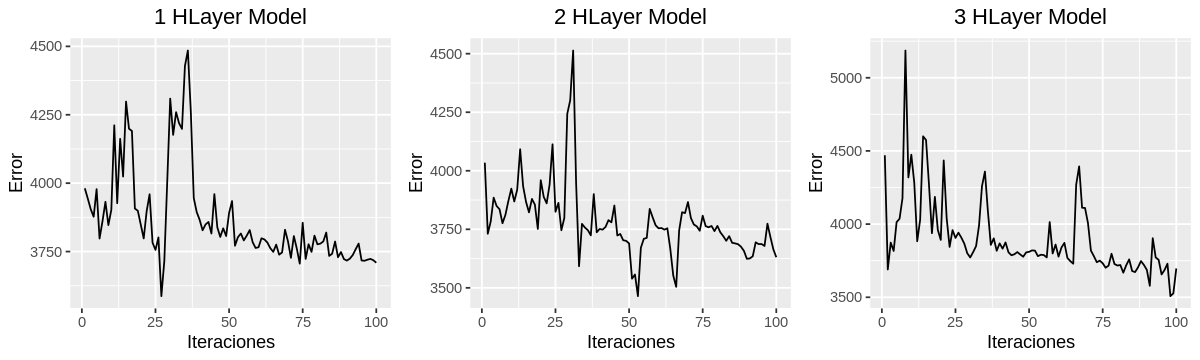

In [27]:
# Configuración del tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=3)

errorNn1Err <- ggplot() + geom_line(aes(x=1:length(nn1LFit$finalModel$IterativeFitError), y=nn1LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2Err <- ggplot() + geom_line(aes(x=1:length(nn2LFit$finalModel$IterativeFitError), y=nn2LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3Err <- ggplot() + geom_line(aes(x=1:length(nn3LFit$finalModel$IterativeFitError), y=nn3LFit$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1Err, errorNn2Err, errorNn3Err, ncol=3)

De las curvas de aprendizaje anteriores podemos ver que en ninguna de ellas el error cometido alcanza un valor estable y está decreciendo en el momento de terminar las iteraciones (100 por defecto).

Pues ahora vamos a generar un modelo fijando el número de neuronas que daba el mejor resultado, pero aumentando el número de iteraciones. Previamente se ha comprovado que para valores mayores de 1000 el error permanece más o menos constante en todos los modelos, por tanto el valor `maxit` se corresponderá con el que mejor resultado de para los datos de validación. Así mismo también fijaremos el ratio de aprendizaje en 0.03 ya que es el que mejores resultados nos da.

In [28]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFitOptimized <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    tuneGrid = data.frame(size=nneurons1L),
    maxit = 500,
    learnFuncParams = c(0.02,0)
)

In [29]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn2LFitOptimized <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    tuneGrid = expand.grid(layer1=nneurons2L1, layer2=nneurons2L2, layer3=0),
    maxit = 1500,
    learnFuncParams = c(0.005,0)
)

In [31]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn3LFitOptimized <- train(
    class ~ .,
    data = training,
    method = "mlpML",
    trControl = crossValidation,
    tuneGrid = expand.grid(layer1=nneurons3L1, layer2=nneurons3L2, layer3=nneurons3L3),
    maxit = 1750,
    learnFuncParams = c(0.005,0)
)

Una vez realizado el entrenamiento de los tres modelos con el número de iteraciones fijado en 1000, 1000 y 1500 podemos volver a obtener los resultados con respecto a los datos de entrenamiento y validación.

In [34]:
# Modelo de una única capa oculta.
nn1LFitOptimized$results[rownames(nn1LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta.
confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$class))$overall[1:4]

# Modelo de 2 capas oculta con 5-7 neuronas.
nn2LFitOptimized$results[rownames(nn2LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn2LFitOptimized,testing), factor(testing$class))$overall[1:4]

# Modelo de tres capas ocultas con 5-5-5 neuronas.
nn3LFitOptimized$results[rownames(nn3LFitOptimized$bestTune),1:4]

# Matriz de confusión para el modelo de una única capa oculta y 7 neuronas.
confusionMatrix(predict(nn3LFitOptimized,testing), factor(testing$class))$overall[1:4]

size,Accuracy,Kappa,AccuracySD
<dbl>,<dbl>,<dbl>,<dbl>
60,0.5996529,0.4394386,0.0753897


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.6945556     0.5810143     0.6760728     0.7125813

layer1,layer2,layer3,Accuracy
<dbl>,<dbl>,<dbl>,<dbl>
65,64,0,0.830574


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8270616     0.7684819     0.8116497     0.8417027

layer1,layer2,layer3,Accuracy
<dbl>,<dbl>,<dbl>,<dbl>
60,59,60,0.8283195


Accuracy         Kappa AccuracyLower AccuracyUpper 
    0.8682946     0.8227524     0.8544008     0.8813186

En los resultados anteriores podemos observar que el modelo de una capa oculta es aquel que mejor precisión nos da sobre los datos de aprendizaje. Pero antes de realizar cualquier conclusión vamos a ver las curvas de apredizaje y realizar los tests binomiales y de t para ver si las diferencias son significativas.

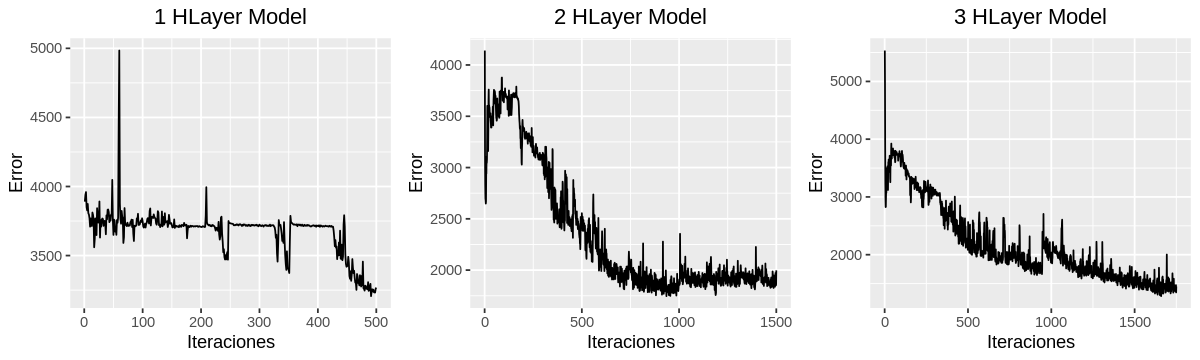

In [35]:
# Configuración del tamaño de las gráficas.
options(repr.plot.width=10, repr.plot.height=3)

errorNn1OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn1LFitOptimized$finalModel$IterativeFitError), y=nn1LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("1 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn2OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn2LFitOptimized$finalModel$IterativeFitError), y=nn2LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("2 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

errorNn3OptimizedErr <- ggplot() + geom_line(aes(x=1:length(nn3LFitOptimized$finalModel$IterativeFitError), y=nn3LFitOptimized$finalModel$IterativeFitError)) +
xlab("Iteraciones") + ylab("Error") + ggtitle("3 HLayer Model") + theme(plot.title = element_text(hjust = 0.5))

grid.arrange(errorNn1OptimizedErr, errorNn2OptimizedErr, errorNn3OptimizedErr, ncol=3)

In [37]:
# Test binomial entre nn1LFitOptimized y nn2LFitOptimized 
binom.test(c(round(confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$class))$overall[1]),
             round(1 - confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$class))$overall[1])
            )*nrow(testing),
           p = confusionMatrix(predict(nn2LFitOptimized,testing), factor(testing$class))$overall[1])

# Test entre n1LFitOptimized y nn2LFitOptimized de validación cruzada.
t.test(nn1LFitOptimized$resample$Accuracy, nn2LFitOptimized$resample$Accuracy,paired = T)


	Exact binomial test

data:  c(round(confusionMatrix(predict(nn1LFitOptimized, testing), factor(testing$class))$overall[1]),     round(1 - confusionMatrix(predict(nn1LFitOptimized, testing),         factor(testing$class))$overall[1])) * nrow(testing)
number of successes = 2498, number of trials = 2498, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.8270616
95 percent confidence interval:
 0.9985244 1.0000000
sample estimates:
probability of success 
                     1 



	Paired t-test

data:  nn1LFitOptimized$resample$Accuracy and nn2LFitOptimized$resample$Accuracy
t = -10.125, df = 9, p-value = 3.227e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2825154 -0.1793269
sample estimates:
mean of the differences 
             -0.2309212 


El test binomial nos indica que durante el entrenamiento no se puede tomar la diferencia como significativa. Los dos modelos ajustan los datos de entrenamiento de manera similar pero el modelo de una única capa oculta es capaz de generalizar mejor.

## Máquinas vector soporte

Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

De la misma forma que con los árboles de decisión para las máquinas de vector soporte encontramos diferentes tipos, Lineares, Polinomial y Radial

In [39]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmLinealFit <- train(
    class ~ .,
    data = training,
    method = "svmLinear",
    trControl = crossValidation,
    tuneGrid = data.frame(C=1),
    scale = FALSE
)

In [40]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmPolyFit <- train(
    class ~ .,
    data = training,
    method = "svmPoly",
    trControl = crossValidation,
    tuneGrid = expand.grid(degree=c(2,3),C=c(1,5),scale = c(0.1, 0.5, 1))
)

In [41]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmRadialFit <- train(
    class ~ .,
    data = training,
    method = "svmRadial",
    trControl = crossValidation, 
    tuneGrid = expand.grid(sigma=c(1,3),C=c(1,5)) 
)

Con los modelos anteriores entrenamos podemos mostrar las precisiones respecto a los datos de entrenamiento y a los datos de validación

In [42]:
svmLinealFit$results[rownames(svmLinealFit$bestTune),1:4]
confusionMatrix(predict(svmLinealFit,testing),factor(testing$class))$overall[1:2]

svmPolyFit$results[rownames(svmPolyFit$bestTune),1:5]
confusionMatrix(predict(svmPolyFit,testing),factor(testing$class))$overall[1:2]

svmRadialFit$results[rownames(svmRadialFit$bestTune),1:4]
confusionMatrix(predict(svmRadialFit,testing),factor(testing$class))$overall[1:2]

C,Accuracy,Kappa,AccuracySD
<dbl>,<dbl>,<dbl>,<dbl>
1,0.8045717,0.7371844,0.04682825


Accuracy     Kappa 
0.8410729 0.7852573

,degree,C,scale,Accuracy,Kappa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,3,1,0.5,0.9684064,0.9576268


Accuracy     Kappa 
0.9675741 0.9565240

,sigma,C,Accuracy,Kappa
,<dbl>,<dbl>,<dbl>,<dbl>
2,1,5,0.9581431,0.9435538


Accuracy     Kappa 
0.9603683 0.9465803

Para los resultados aportados por los modelos anteriores no es necesario realizar ningún test de validación ya que a simple vista se puede ver que el modelo lineal tiene una precisión muy superior al resto de modelos.

## Comparación de los paradigmas

Para realizar la comparación de los paradigmas explorados seleccionaremos sólo aquellos modelos que durante el desarrollo de la práctica identificamos como los _mejores_. Estos fueron: **C4.5** para árboles de decisión, **knn** para vecinos más cercanos, el modelo de **una única capa oculta optimizado en iteraciones** para las redes neuronales y finalmente el **modelo lineal** para las máquinas de vector soporte. Los resultados obtenidos para la validación externa de cada paradigma són los siguientes.

In [53]:
c4.5Fit.accuracy <- confusionMatrix(predict(c4.5Fit,testing), factor(testing$class))$overall[1:1]
cat("C4.5 -", c4.5Fit.accuracy, "\n")

knnFit.accuracy <- confusionMatrix(predict(knnFit,testing), factor(testing$class))$overall[1:1]
cat("knn -", knnFit.accuracy, "\n")

nn1LFitOptimized.accuracy <- confusionMatrix(predict(nn1LFitOptimized,testing), factor(testing$class))$overall[1:1]
cat("nn1L -", nn1LFitOptimized.accuracy, "\n")

svmLinealFit.accuracy <- confusionMatrix(predict(svmLinealFit,testing), factor(testing$class))$overall[1:1]
cat("svmLineal -", svmLinealFit.accuracy, "\n")

C4.5 - 0.9491593 
knn - 0.9719776 
nn1L - 0.6945556 
svmLineal - 0.8410729 


Ahora realizaremos las comparaciones con el test binomial entre el modelo que parece más preciso, nn1L y el resto de modelos.

In [44]:
# Test binomial entre knn y c4.5 
binom.test(c(round(nn1LFitOptimized.accuracy), round(1-nn1LFitOptimized.accuracy))*nrow(testing), p = c4.5Fit.accuracy)


	Exact binomial test

data:  c(round(nn1LFitOptimized.accuracy), round(1 - nn1LFitOptimized.accuracy)) *     nrow(testing)
number of successes = 2498, number of trials = 2498, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.9491593
95 percent confidence interval:
 0.9985244 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo nn1L y el modelo c4.5 nos dice que nn1L es significativamente más preciso para los datos de validación.

In [45]:
# Test binomial entre knn y nn1L 
binom.test(c(round(nn1LFitOptimized.accuracy), round(1-nn1LFitOptimized.accuracy))*nrow(testing), p = knnFit.accuracy)


	Exact binomial test

data:  c(round(nn1LFitOptimized.accuracy), round(1 - nn1LFitOptimized.accuracy)) *     nrow(testing)
number of successes = 2498, number of trials = 2498, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.9711769
95 percent confidence interval:
 0.9985244 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo nn1L y el modelo knn nos dice que nn1L es significativamente más preciso para los datos de validación.

In [49]:
# Test binomial entre knn y svmPolyFit 
binom.test(c(round(nn1LFitOptimized.accuracy), round(1-nn1LFitOptimized.accuracy))*nrow(testing), p = svmLinealFit.accuracy)


	Exact binomial test

data:  c(round(nn1LFitOptimized.accuracy), round(1 - nn1LFitOptimized.accuracy)) *     nrow(testing)
number of successes = 2498, number of trials = 2498, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.8410729
95 percent confidence interval:
 0.9985244 1.0000000
sample estimates:
probability of success 
                     1 


El test binomial entre el modelo nn1L y el modelo svmLineal nos dice que nn1L es significativamente más preciso para los datos de validación.

Ahora observemos una gráfica de comparación con los modelos más precisos de cada paradigma.

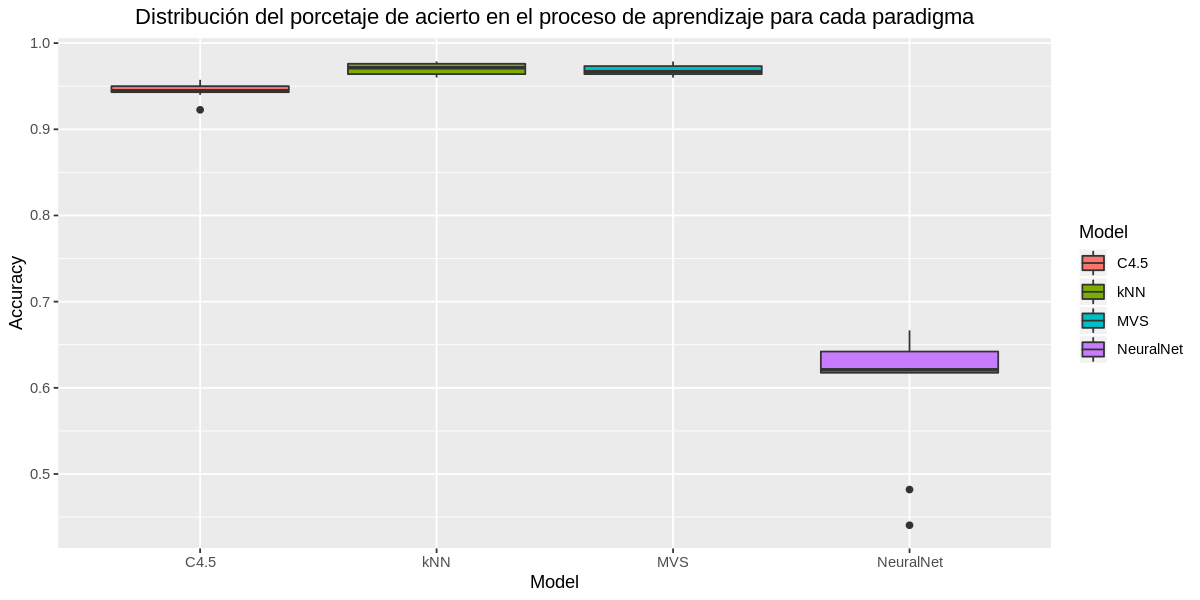

In [50]:
options(repr.plot.width=10, repr.plot.height=5)
dfm.resamp <- data.frame(Accuracy = c(nn1LFitOptimized$resample$Accuracy,
                                      c4.5Fit$resample$Accuracy,
                                      knnFit$resample$Accuracy,
                                      svmPolyFit$resample$Accuracy), 
                        Model = rep(c('NeuralNet','C4.5','kNN', 'MVS'), each=10))
ggplot(dfm.resamp,aes(x=Model, y=Accuracy, fill=Model)) + geom_boxplot() +
ggtitle("Distribución del porcetaje de acierto en el proceso de aprendizaje para cada paradigma") +
theme(plot.title = element_text(hjust = 0.5))

De las comparaciones anteriores y la gráfica final se puede deducir que el modelo de red neuronal con una única capa oculta es aquel que presenta una mayor precisión sobre los datos de validación. Así mismo, comparado con los modelos knn y máquinas vector soporte, los modelos que tiene una precisión similar, es el modelo de redes neuronales el que es más estable. Sin embargo de entre todos los modelos el más estable es el de c4.5, que también es el que menos precisión nos da.